In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import concurrent.futures
from tqdm.notebook import tqdm


# Authenticate with W&B
wandb.login(timeout=1024)

# Configure project and other parameters if necessary
project_name = "contrastive_exploration_reward_max"
entity = "pletctj6"

# Retrieve the runs from the project
api = wandb.Api()
runs = api.runs(f"{entity}/{project_name}")

# Initialize a list to store coverage and shannon entropy data
experiments_data = {}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pletctj6. Use `wandb login --relogin` to force relogin


#### show nb finished 

### Downloading the data

* config : config for the run
* history : Time evolution of all the data recorded during the run as columns in a pandas dataframe
* summary : last sample of the data recorded

In [71]:
from envs.config_env import config as config_env

def process_run(run, 
                metrics = {
                            "config": ["exp_name", "env_id", "seed", "keep_extrinsic_reward", "beta_ratio", "use_sigmoid", "feature_extractor"],
                            "history": ["specific/episodic_return", "specific/coverage", "specific/shanon_entropy", "global_step"],
                            "summary": ["specific/episodic_return", "specific/coverage", "specific/shanon_entropy", "global_step"]
                },
                config_env=config_env):
    # Vérification de l'état du run
    # if run.state != "finished":
    #     # print(f"Skipping run {run.name} because it is not finished.")
    #     return None
    ##### CONFIGURATION #####
    config = run.config
    config_metrics = {key: None for key in metrics['config']}
    for key in config_metrics.keys():
        try:
            config_metrics[key] = config.get(key)
        except:
            print(f"Skipping run {run.name} because it doesn't have the necessary data.")
            return None
        
    ##### HISTORY #####
    history = run.history()
    history_metrics = {key: None for key in metrics['history']}
    for key in history_metrics.keys():
        if key in history.columns:
            history_metrics[key] = history[key]
        else:
            print(f"Skipping run {run.name} because it doesn't have the necessary data.")
            return None

    ##### SUMMARY #####
    summary_metrics = {key: None for key in metrics['summary']}
    for key in summary_metrics.keys():
        if key in run.summary:
            summary_metrics[key] = run.summary[key]
        else:
            print(f"Skipping run {run.name} because it doesn't have the necessary data.")
            return None
        
    #### STATUS ####
    status = run.state

    if status != "finished":
        print(f"Skipping run {run.name} because it is not finished.")
        return None

        
    # Check env id 
    type_id = config_env[run.config.get('env_id')]['type_id']
    return {
        'exp_name': config_metrics['exp_name'],
        'env_name': config_metrics['env_id'],
        'type_id': type_id,
        'seed': config_metrics['seed'],
        'data': {
            'summary_metrics': summary_metrics,
            'history_metrics': history_metrics,
            'config_metrics': config_metrics,
            'config': config,
            'status': status
        }
    }

experiments_data = {}
max_workers = 2
nb_runs_finished = 0
# Utilisation de ThreadPoolExecutor pour paralléliser les exécutions de runs
# Spécifiez le nombre de threads avec max_workers, par exemple 4 threads
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(process_run, run) for run in runs}
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing runs"):
        result = future.result()
        if result is not None:
            exp_name = result['exp_name']
            env_name = result['env_name']
            type_id = result['type_id']
            seed = result['seed']
            data = result['data']
            if exp_name not in experiments_data:
                experiments_data[exp_name] = {}
            if type_id not in experiments_data[exp_name]:
                experiments_data[exp_name][type_id] = {}
            if env_name not in experiments_data[exp_name][type_id]:
                experiments_data[exp_name][type_id][env_name] = {}
            if seed not in experiments_data[exp_name][type_id][env_name]:
                experiments_data[exp_name][type_id][env_name][seed] = data
            nb_runs_finished += 1 if data['status'] == 'finished' else 0
print(f"Number of finished runs: {nb_runs_finished}")

Processing runs:   0%|          | 0/635 [00:00<?, ?it/s]

Skipping run Ant-v3__ppo__5 because it doesn't have the necessary data.
Skipping run Reacher-v4__rnd_ppo__5 because it doesn't have the necessary data.
Skipping run Reacher-v4__rnd_ppo__2 because it doesn't have the necessary data.
Skipping run Reacher-v4__rnd_ppo__4 because it doesn't have the necessary data.
Skipping run Reacher-v4__rnd_ppo__3 because it doesn't have the necessary data.
Skipping run Reacher-v4__rnd_ppo__1 because it doesn't have the necessary data.
Skipping run HumanoidStandup-v4__ngu_ppo__2 because it doesn't have the necessary data.
Skipping run HumanoidStandup-v4__ngu_ppo__3 because it doesn't have the necessary data.
Skipping run HumanoidStandup-v4__ngu_ppo__4 because it doesn't have the necessary data.
Skipping run HumanoidStandup-v4__ngu_ppo__1 because it doesn't have the necessary data.
Skipping run Reacher-v4__icm_ppo__3 because it doesn't have the necessary data.
Skipping run Reacher-v4__icm_ppo__2 because it doesn't have the necessary data.
Skipping run Rea

#### Check data

In [3]:
experiments_data['apt_ppo']['mujoco']['HalfCheetah-v3'][3]['history_metrics']['specific/episodic_return']
# # check nan in data
# is_nan = experiments_data['apt_ppo']['mujoco']['HalfCheetah-v3'][3]['history_metrics']['specific/episodic_return'].isnull().values.any()
# print(is_nan)

0     -663.225281
1     -644.925720
2     -733.522705
3     -644.028198
4     -600.349548
          ...    
495           NaN
496   -483.393768
497   -471.852509
498   -474.179840
499   -493.967560
Name: specific/episodic_return, Length: 500, dtype: float64

### Learning Curve

#### Change name

In [72]:
def traductor_exp(exp_name:str):
    # split name by _
    list_words = exp_name.split("_")
    if 'v1' in list_words: 
        if 'kl' in list_words:
            name = "V1KL"
        elif 'lipshitz' in list_words:
            name = "V1W"
    elif 'v2' in list_words:
        if 'kl' in list_words:
            name = "V2KL"
        elif 'lipshitz' in list_words:
            name = "V2W"
    else:
        # remove _ppo at the end
        name = list_words[0]
    # Upper case
    name = name.upper()
    return name


##### list + params colors

In [73]:
# algo
list_algos = list(experiments_data.keys())
# type
list_type = list(experiments_data[list_algos[0]].keys())
# env
list_env = []
for i in range(len(list_type)):
    list_env += list(list(experiments_data[list_algos[0]][list_type[i]].keys()))

print(list_algos)
print(list_type)
print(list_env)

['ppo', 'rnd_ppo', 'ngu_ppo', 'icm_ppo', 'aux_ppo', 'apt_ppo']
['maze', 'robotics', 'dmcs', 'mujoco']
['Maze-Ur-v0', 'Maze-Easy-v0', 'Maze-Hard-v0', 'FetchReach-v1', 'FetchSlide-v2', 'FetchPush-v2', 'DMCS-Ball-in-cup-v0', 'DMCS-Cart-k-Pole-v0', 'DMCS-Acrobot-v0', 'DMCS-Finger-v0', 'DMCS-Fish-v0', 'HalfCheetah-v3', 'Hopper-v3', 'Ant-v3', 'Walker2d-v3', 'Humanoid-v3', 'HumanoidStandup-v4', 'Reacher-v4', 'Swimmer-v3']


In [74]:
# unique colors per exp_name 
palette = plt.get_cmap("tab20").colors
color_map = {exp_name: palette[i % len(palette)] for i, exp_name in enumerate(list_algos)}

In [77]:
import pandas as pd
import numpy as np
import os
from tabulate import tabulate

def concat_time_serie(experiments_data, 
                        keys=["specific/episodic_return", "specific/coverage", "specific/shanon_entropy", "global_step"], 
                        type_id_default = None, 
                        env_name_default = None):
    key_data = {}
    for exp_name in experiments_data.keys():
        key_data[exp_name] = {} if exp_name not in key_data else key_data[exp_name]
        for type_id in experiments_data[exp_name].keys():
            if type_id_default is not None and type_id not in type_id_default:
                continue
            key_data[exp_name][type_id] = {} if type_id not in key_data[exp_name] else key_data[exp_name][type_id]
            for env_name in experiments_data[exp_name][type_id].keys():
                if env_name_default is not None and env_name not in env_name_default:
                    continue
                key_data[exp_name][type_id][env_name] = {} if env_name not in key_data[exp_name][type_id] else key_data[exp_name][type_id][env_name]
                for key in keys:
                    df_metric =pd.concat([experiments_data[exp_name][type_id][env_name][seed]['history_metrics'][key] \
                                 for seed in experiments_data[exp_name][type_id][env_name].keys()], axis=1)
                    df_clean = df_metric.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0) #wandb issues
                    try : 
                        key_data[exp_name][type_id][env_name][key] = {} if key not in key_data[exp_name][type_id][env_name] else key_data[exp_name][type_id][env_name][key]
                        key_data[exp_name][type_id][env_name][key]['mean'] = df_clean.mean(axis=1)
                        key_data[exp_name][type_id][env_name][key]['std'] = df_clean.std(axis=1)
                        key_data[exp_name][type_id][env_name][key]['global_step'] = experiments_data[exp_name][type_id][env_name][seed]['history_metrics']['global_step']
                    except:
                        print(f"Error in {exp_name} {type_id} {env_name} {key}")
    # key_df = {}
    # for key in keys:
    #     key_df[key] = pd.DataFrame(key_data[key])
    return key_data

key_data = concat_time_serie(experiments_data, type_id_default=list_type, env_name_default=list_env)

Error in ngu_ppo mujoco Walker2d-v3 specific/episodic_return
Error in ngu_ppo mujoco Walker2d-v3 specific/coverage
Error in ngu_ppo mujoco Walker2d-v3 specific/shanon_entropy
Error in ngu_ppo mujoco Walker2d-v3 global_step
Error in ngu_ppo dmcs DMCS-Fish-v0 specific/episodic_return
Error in ngu_ppo dmcs DMCS-Fish-v0 specific/coverage
Error in ngu_ppo dmcs DMCS-Fish-v0 specific/shanon_entropy
Error in ngu_ppo dmcs DMCS-Fish-v0 global_step
Error in ngu_ppo robotics FetchSlide-v2 specific/episodic_return
Error in ngu_ppo robotics FetchSlide-v2 specific/coverage
Error in ngu_ppo robotics FetchSlide-v2 specific/shanon_entropy
Error in ngu_ppo robotics FetchSlide-v2 global_step
Error in ngu_ppo robotics FetchPush-v2 specific/episodic_return
Error in ngu_ppo robotics FetchPush-v2 specific/coverage
Error in ngu_ppo robotics FetchPush-v2 specific/shanon_entropy
Error in ngu_ppo robotics FetchPush-v2 global_step
Error in ngu_ppo maze Maze-Hard-v0 specific/episodic_return
Error in ngu_ppo maze Ma

In [78]:
key_data[list(key_data.keys())[0]].keys()

dict_keys(['maze', 'robotics', 'dmcs', 'mujoco'])

#### plot

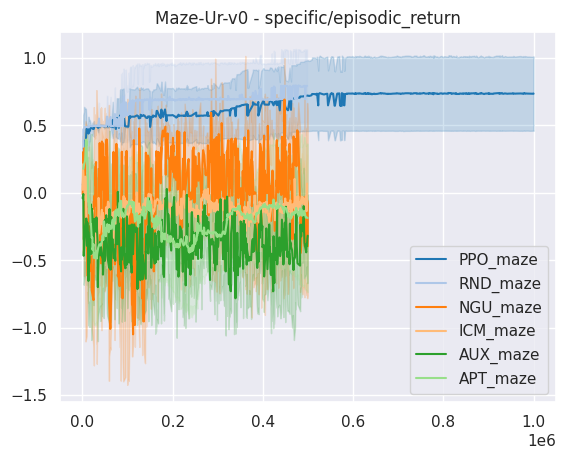

Error in ngu_ppo Maze-Easy-v0


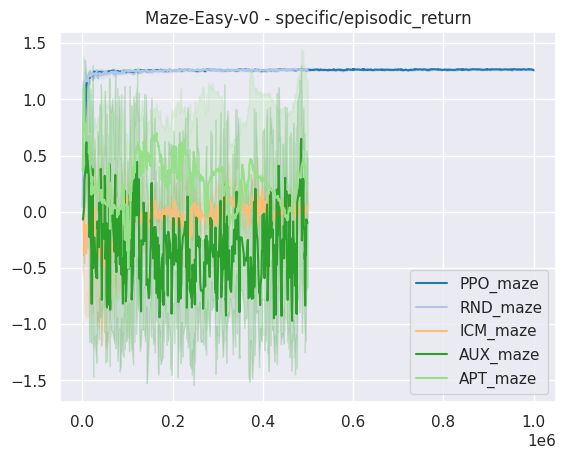

Error in ngu_ppo Maze-Hard-v0


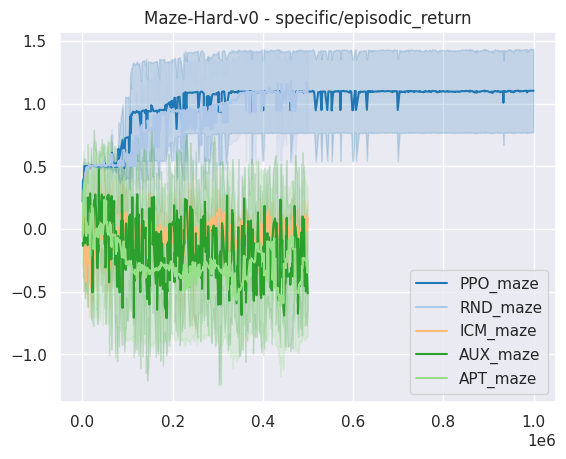

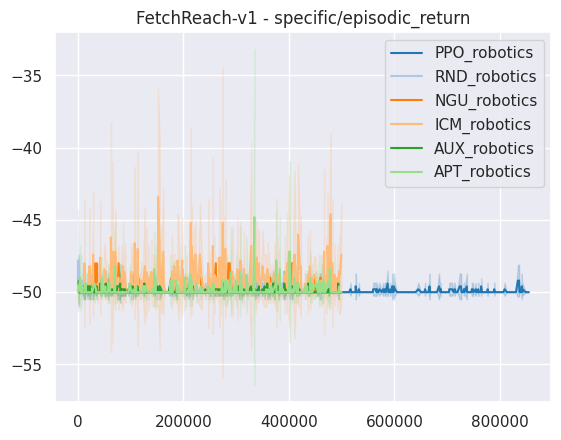

Error in ngu_ppo FetchSlide-v2


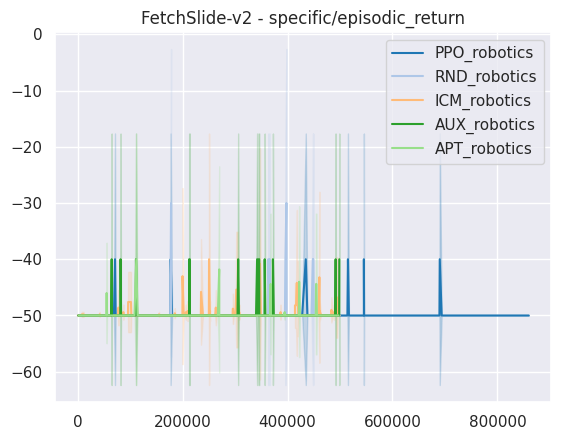

Error in ngu_ppo FetchPush-v2


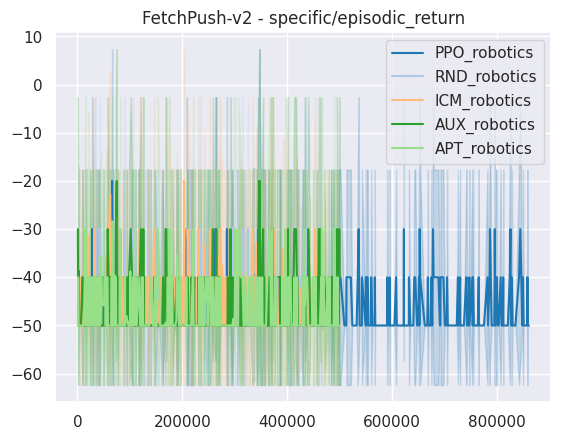

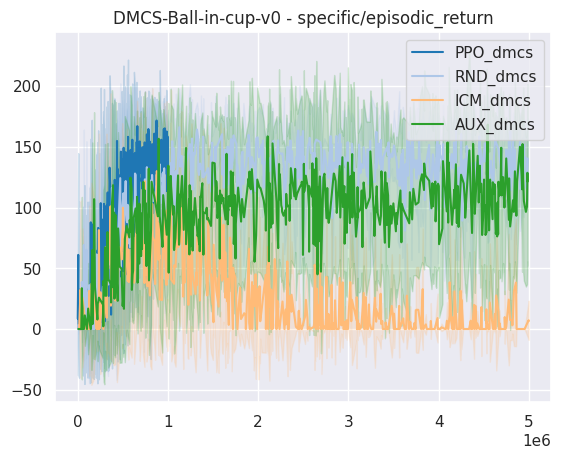

Error in icm_ppo DMCS-Cart-k-Pole-v0
Error in aux_ppo DMCS-Cart-k-Pole-v0


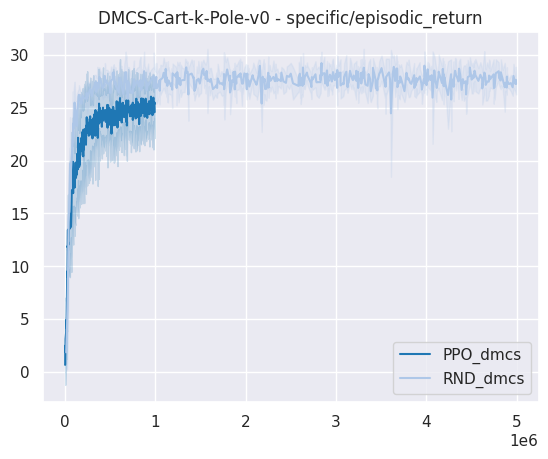

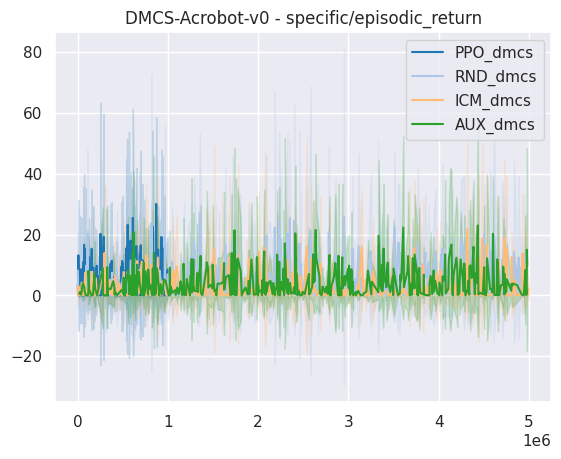

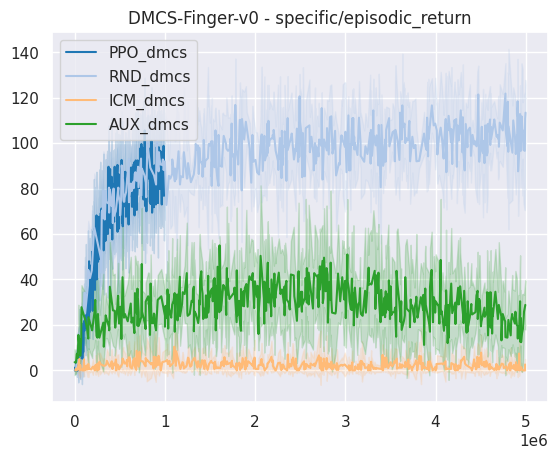

Error in ngu_ppo DMCS-Fish-v0


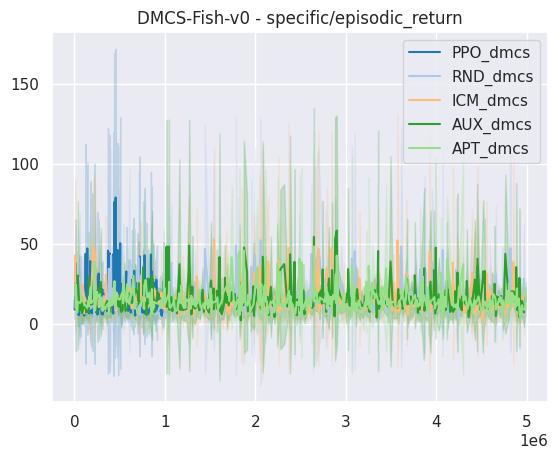

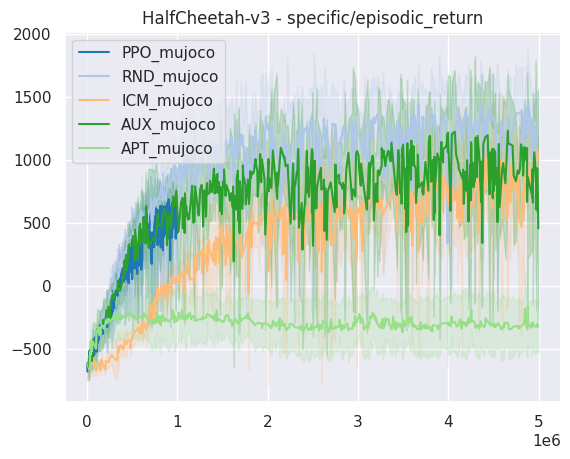

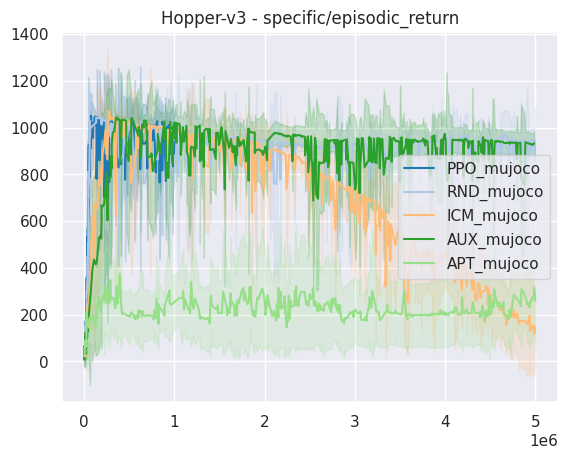

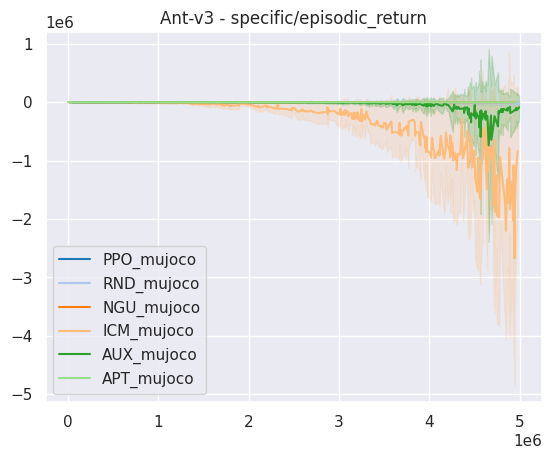

Error in ngu_ppo Walker2d-v3


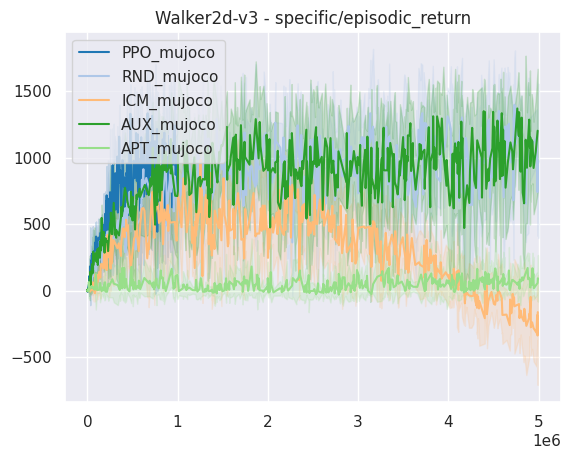

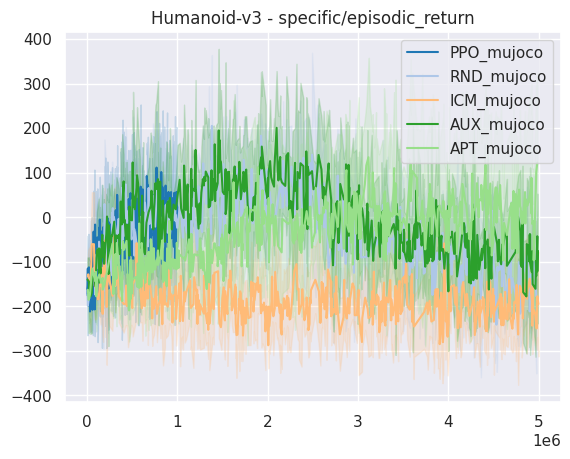

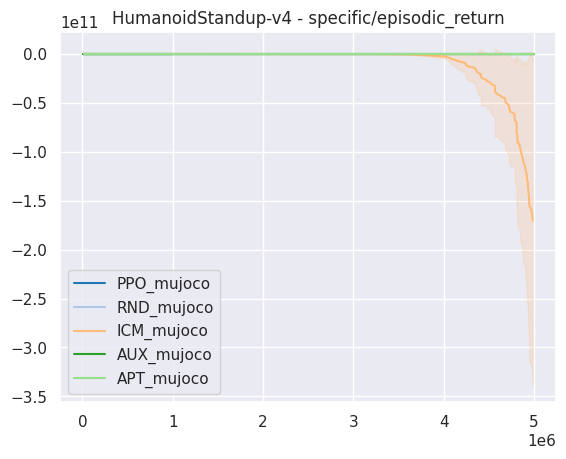

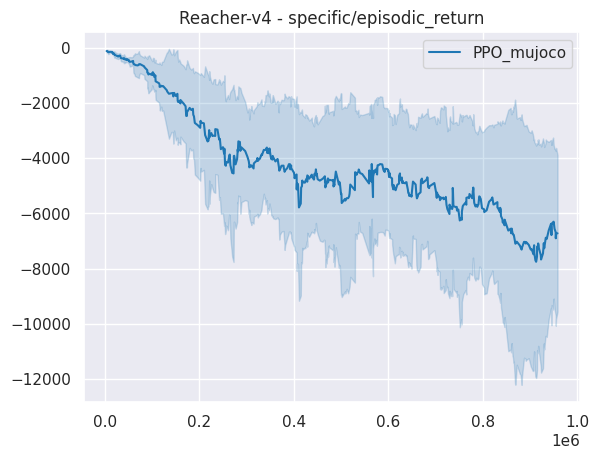

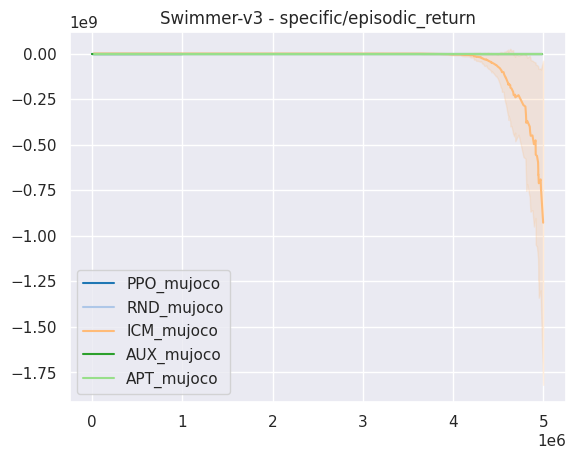

In [80]:
# figure per env
# seaborn style
sns.set(style="darkgrid")
keys = ["specific/episodic_return"]
for env_name in list_env:
    fig, ax = plt.subplots()
    for exp_name in list_algos:
        try : 
            for type_id in list_type:
                if env_name not in key_data[exp_name][type_id].keys():
                    continue
                for key in keys:
                    if key not in key_data[exp_name][type_id][env_name].keys():
                        continue
                    ax.plot(key_data[exp_name][type_id][env_name][key]['global_step'], key_data[exp_name][type_id][env_name][key]['mean'], label=f"{traductor_exp(exp_name)}_{type_id}", color=color_map[exp_name])
                    ax.fill_between(key_data[exp_name][type_id][env_name][key]['global_step'], 
                                    key_data[exp_name][type_id][env_name][key]['mean'] - key_data[exp_name][type_id][env_name][key]['std'],
                                    key_data[exp_name][type_id][env_name][key]['mean'] + key_data[exp_name][type_id][env_name][key]['std'], alpha=0.2, color=color_map[exp_name])
        except:
            print(f"Error in {exp_name} {env_name}")
    ax.set_title(f'{env_name} - {keys[0]}')
    ax.legend()
    plt.show()


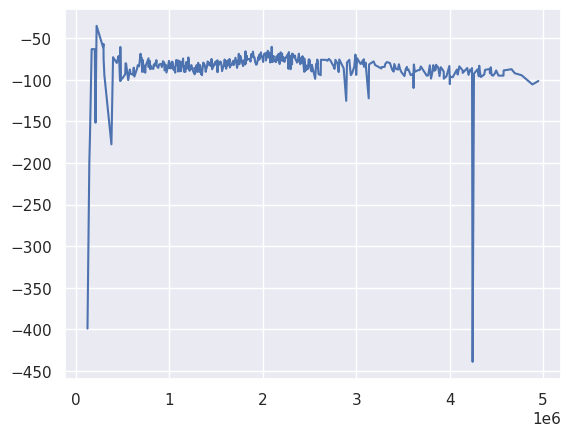

In [83]:
# plot specific run 
algo = 'ngu_ppo'
type_id = 'mujoco'
env_name = 'Ant-v3'
seed = 1
keys = ["specific/episodic_return"]
fig, ax = plt.subplots()
for key in keys:
    ax.plot(experiments_data[algo][type_id][env_name][seed]['history_metrics']['global_step'], experiments_data[algo][type_id][env_name][seed]['history_metrics'][key], label=f"{traductor_exp(algo)}_{type_id}")
    